# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [4]:
# Necessary imports
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [5]:
def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=400, batch_size=32, patience=15):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

# 3rd assignment

Let's first implement the Bahdanau Attention and Luong General Attention functions, as well as the visualization tools for the visualization of the attention weights. 

After that, a comparison will be performed for the 3 cases (Luong Dot Attention and the former 2) to see their difference with respect to performance.

## Attention mechanisms

Let's remind our task is to implement the scores for the attention mechanism. The input of the score function will take each of the elements (regarding the second axis) of:
- The decoder output (the last hidden state at first) $h$: vector with shape (``rnn_units``, ``n_timesteps_out`` = 1)
- The encoder's hidden states (all of them) $\overline{h}$: an array with shape (``rnn_units``, ``n_timesteps_in``)
(in the Tensorflow implementation we would another first axis with the batch size)
And then it should a return an attention weight vector with shape (``n_timesteps_in``, ``n_timesteps_out`` = 1) which can be understood as the probability of relevance of each element of the input sequence with the respect to the current prediction: in this case, ``n_timesteps_out`` = 1 element at a time.

Equivalently, if we traverse the $h$ decoder output vector second axis with index $t$ (in this case $t\in \{1\}$),
$h_t$, and the encoder hidden states vector second axis with index $s$ (in this case $s\in \{1, \ldots, S\equiv n_{steps_{out}} = 20\}$), $\overline{h}_s$; then the context vector will be:
$$ c_t = \sum_{s=1}^{S=20} \alpha_{ts} \overline{h}_s$$
(for each decoder output element $t$, in our case 1 per step) being $\alpha_{ts}$ the attention weights computed as a probability: thus, using a 'softmax' after applying the score $\mathrm{score}(h_t, \overline{h}_s)$ function:
$$ \alpha_{ts} =  \frac{e^{\mathrm{score}(h_t, \overline{h}_s)}}{\sum_{s'=1}^{S=20}e^{\mathrm{score}(h_t, \overline{h}_s')}}$$

Regarding the implementation of this score, there are different possibilities in function of the technique. Let's see first the Luong Dot Attention implementation:

In [6]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vector, attention_weights

Below the Luong General Attention score and the Bahdanau Additive Attention score are implemented, very simple once the Luong Dot Attention is clear, for they are no more than a generalization consisting in the addition of some trainable matrices. 

In [7]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # where the number of units will have to be coincident with rnn_units
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        # single hidden layer network model (vector-shaped)
        self.v = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.v(tf.nn.tanh(self.w1(query_with_time_axis) + self.w2(values)))
        # softmax to convert the attention weights to normalized values
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # and the 'scalar product' to obtain the context vector
        context_vector = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vector, attention_weights

In [8]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        # much easier than before: just 1 matrix needed 
        # (still units = ``rnn_units``)
        self.w = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(self.w(values), perm=[0, 2, 1])  # and already multiplied by the matrix
        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])   
        # softmax...
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        # and finally the context vector
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Attention weights visualization 

Before everything we need to recover not only the attention model, but also the encoders and decoders conforming it in order to visualize the weights. Thus, we must modify a little bit the original function:

In [9]:
tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

Now, once the model are compiled and trained, we need to gather the output with the former trained we need to gather:
- The attention weights so that they can be later plotted
- The input sequence to set it in the horizontal axis
- The predicted sequence to set it in the vertical axis

The function to do so is presented below and actually is almost a copy-paste of the previous one but without the compilation/retrieval of neither the model nor the encoders/decoders:

In [10]:
def gather_weights(input_seq, encoder_lstm, decoder_lstm, decoder_dense, attention):
    plot_grid: np.ndarray = np.zeros((n_timesteps_in, n_timesteps_in))

    # sequence passed to the encoder to gather the hidden states
    encoder_inputs = np.array(one_hot_encode(input_seq, n_features)).reshape(
        1, n_timesteps_in,n_features)
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    states = [encoder_state_h, encoder_state_c]
    all_outputs = []

    # the first decoder output is the last encoder hidden state
    decoder_inputs = np.zeros((1, 1, n_features))
    decoder_inputs[:, 0, 0] = 1 
    _inputs = decoder_inputs
    decoder_outputs = encoder_state_h

    # we begin storing the weights using the same loop (and we'll obtain 
    # the predicted sequence)
    for t in range(n_timesteps_in):
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)
        _inputs = tf.concat([context_vector, _inputs], axis=-1)

        decoder_outputs=tf.expand_dims(decoder_outputs, 1)
        decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(_inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        _inputs = outputs
        states = [encoder_state_h, encoder_state_c]
        
        # attention weights
        attention_weights = tf.reshape(attention_weights, (-1, ))  # we flatten them
        # and we store them as rows (second axis) the attention weights
        plot_grid[t] = attention_weights.numpy()
    
    # we finally we obtain the predicted sequence
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    predicted_seq=one_hot_decode(decoder_outputs[0])

    return input_seq, predicted_seq, plot_grid

Finally, we plot them:

In [11]:
import matplotlib.ticker as ticker

def _plot(grid, input_seq, predicted_seq):
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(grid[::-1, :], cmap='Greys')
    # input sequence as horizontal axis
    ax.set_xticklabels([''] + input_seq, rotation=90)
    # we want to display ALL the labels
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # predicted sequence as vertical axis
    ax.set_yticklabels([''] + predicted_seq)    
    # we want to display ALL the labels
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show();
    
def plot_attention_model_weights(input_seq, encoder_lstm, decoder_lstm, decoder_dense, model):
    input_seq, predicted_seq, plot_grid = gather_weights(
        input_seq, encoder_lstm, decoder_lstm, decoder_dense, model)
    _plot(plot_grid, input_seq, predicted_seq)

### Dataset definition

In [12]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, n_features)

### Hyperparameters setting

In [13]:
# model parameters
rnn_units = 200
# training parameters
batch_size = 100
n_epochs: int = 250
patience: int = 30

# Comparative: performance and weights visualization

In [14]:
# we will visualize the weights after processing the following sequence
# once the different attention models are trained
test_seq = generate_sequence(n_timesteps_in, n_features)

## Luong Dot Attention

2022-12-24 11:02:15.247092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 11:02:15.248093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 11:02:15.578065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 11:02:15.578870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 11:02:15.579620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/250


2022-12-24 11:04:28.475199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 155s 2s/step - loss: 2.9587 - accuracy: 0.0556 - val_loss: 2.9460 - val_accuracy: 0.0548
Epoch 2/250
18/18 [==============================] - 10s 585ms/step - loss: 2.9432 - accuracy: 0.0609 - val_loss: 2.9383 - val_accuracy: 0.0664
Epoch 3/250
18/18 [==============================] - 10s 553ms/step - loss: 2.9329 - accuracy: 0.0725 - val_loss: 2.9273 - val_accuracy: 0.0788
Epoch 4/250
18/18 [==============================] - 11s 587ms/step - loss: 2.9165 - accuracy: 0.0834 - val_loss: 2.9121 - val_accuracy: 0.0840
Epoch 5/250
18/18 [==============================] - 10s 580ms/step - loss: 2.9000 - accuracy: 0.0897 - val_loss: 2.8946 - val_accuracy: 0.0913
Epoch 6/250
18/18 [==============================] - 10s 564ms/step - loss: 2.8871 - accuracy: 0.0937 - val_loss: 2.8851 - val_accuracy: 0.0939
Epoch 7/250
18/18 [==============================] - 11s 589ms/step - loss: 2.8766 - accuracy: 0.0977 - val_loss: 2.8744 - val_accuracy: 0.0984
Epoch 

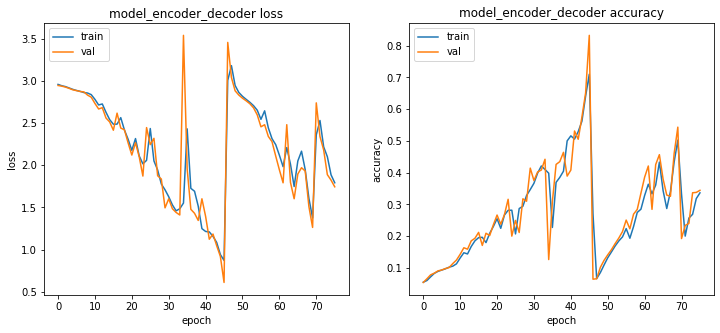

In [12]:
# selection of the attention model
attention_lda = LuongDotAttention()
model_attention_lda, encoder_lstm_lda, decoder_lstm_lda, decoder_dense_lda = build_attention_model(attention_lda, batch_size, rnn_units)
#training
train_test(model_attention_lda, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=n_epochs, patience=patience)

predicted_seq [9, 17, 12, 18, 19, 11, 13, 19, 2, 9, 7, 12, 19, 5, 7, 13, 4, 17, 13, 7, 11, 6, 17, 19, 15, 19, 15, 18, 9, 18, 13, 7, 8, 18, 3, 17, 10, 4, 12, 12, 17, 17, 16, 4, 12, 3, 12, 12, 15, 10, 5, 4, 16, 6, 16, 9, 10, 8, 1, 12, 19, 13, 6, 15, 17, 7, 1, 8, 7, 19, 10, 2, 4, 17, 16, 6, 6, 15, 3, 3, 15, 11, 17, 17, 18, 8, 12, 5, 14, 14, 14, 12, 12, 12, 12, 12, 1, 1, 5, 5]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":


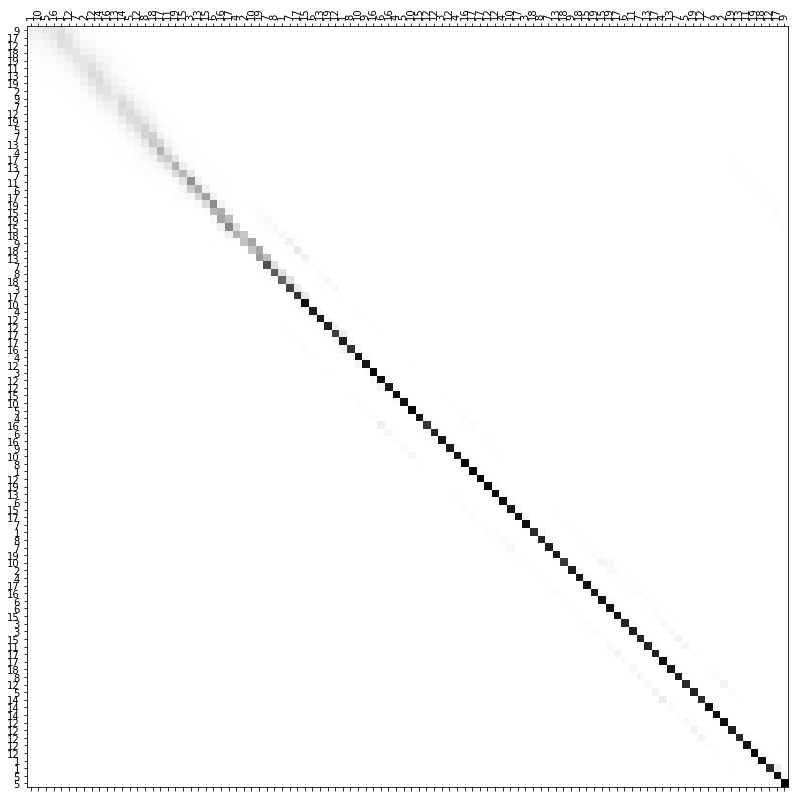

In [13]:
plot_attention_model_weights(
    test_seq, encoder_lstm_lda, decoder_lstm_lda, decoder_dense_lda, attention_lda)

# Bahdanau Attention

Epoch 1/250
18/18 [==============================] - 188s 4s/step - loss: 2.9592 - accuracy: 0.0532 - val_loss: 2.9452 - val_accuracy: 0.0553
Epoch 2/250
18/18 [==============================] - 40s 2s/step - loss: 2.9424 - accuracy: 0.0618 - val_loss: 2.9411 - val_accuracy: 0.0683
Epoch 3/250
18/18 [==============================] - 39s 2s/step - loss: 2.9362 - accuracy: 0.0697 - val_loss: 2.9282 - val_accuracy: 0.0780
Epoch 4/250
18/18 [==============================] - 39s 2s/step - loss: 2.9188 - accuracy: 0.0811 - val_loss: 2.9178 - val_accuracy: 0.0848
Epoch 5/250
18/18 [==============================] - 39s 2s/step - loss: 2.9062 - accuracy: 0.0871 - val_loss: 2.9000 - val_accuracy: 0.0902
Epoch 6/250
18/18 [==============================] - 39s 2s/step - loss: 2.8886 - accuracy: 0.0930 - val_loss: 2.8841 - val_accuracy: 0.0954
Epoch 7/250
18/18 [==============================] - 40s 2s/step - loss: 2.8743 - accuracy: 0.0974 - val_loss: 2.8696 - val_accuracy: 0.0989
Epoch 8/250


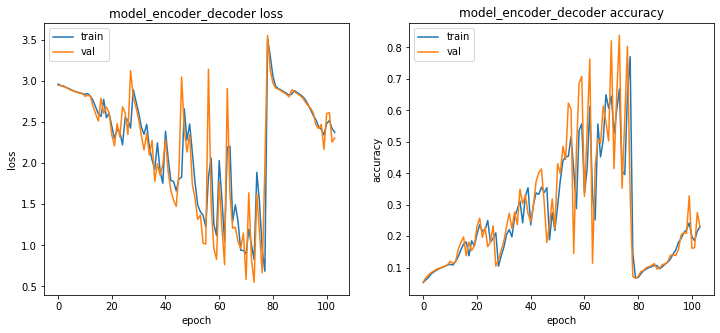

In [14]:
# let's remind the ``units = rnn_units``!
attention_ba = BahdanauAttention(rnn_units)
model_attention_ba, encoder_lstm_ba, decoder_lstm_ba, decoder_dense_ba = build_attention_model(
    attention_ba, batch_size, rnn_units)
train_test(model_attention_ba, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=n_epochs, patience=patience)

predicted_seq [9, 17, 12, 18, 19, 11, 13, 19, 2, 9, 7, 12, 19, 5, 7, 13, 4, 17, 13, 7, 11, 6, 17, 19, 15, 15, 15, 18, 9, 18, 13, 7, 8, 18, 3, 17, 10, 4, 12, 12, 17, 17, 17, 16, 12, 12, 12, 12, 15, 10, 5, 4, 16, 16, 16, 9, 10, 8, 1, 12, 19, 13, 6, 15, 17, 7, 1, 8, 7, 19, 10, 2, 4, 17, 16, 6, 15, 15, 3, 15, 19, 11, 17, 18, 8, 12, 5, 14, 14, 14, 14, 12, 12, 12, 12, 1, 1, 1, 1, 1]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":


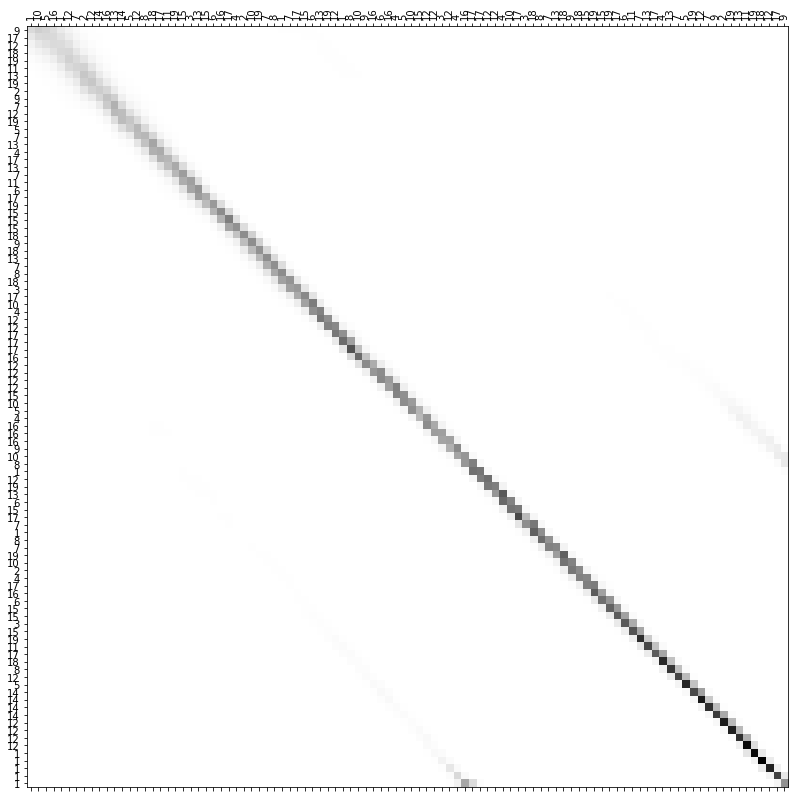

In [15]:
plot_attention_model_weights(
    test_seq, encoder_lstm_ba, decoder_lstm_ba, decoder_dense_ba, attention_ba)

# Luong General Attention

2022-12-24 17:43:23.321602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 17:43:23.322496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 17:43:23.592474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 17:43:23.593382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 17:43:23.594155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/300


2022-12-24 17:45:41.962597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 186s 4s/step - loss: 2.9568 - accuracy: 0.0539 - val_loss: 2.9446 - val_accuracy: 0.0614
Epoch 2/300
18/18 [==============================] - 36s 2s/step - loss: 2.9435 - accuracy: 0.0604 - val_loss: 2.9395 - val_accuracy: 0.0691
Epoch 3/300
18/18 [==============================] - 36s 2s/step - loss: 2.9335 - accuracy: 0.0720 - val_loss: 2.9281 - val_accuracy: 0.0728
Epoch 4/300
18/18 [==============================] - 36s 2s/step - loss: 2.9209 - accuracy: 0.0806 - val_loss: 2.9127 - val_accuracy: 0.0852
Epoch 5/300
18/18 [==============================] - 35s 2s/step - loss: 2.9057 - accuracy: 0.0877 - val_loss: 2.8986 - val_accuracy: 0.0874
Epoch 6/300
18/18 [==============================] - 35s 2s/step - loss: 2.8919 - accuracy: 0.0928 - val_loss: 2.8858 - val_accuracy: 0.0944
Epoch 7/300
18/18 [==============================] - 36s 2s/step - loss: 2.8778 - accuracy: 0.0979 - val_loss: 2.8720 - val_accuracy: 0.0989
Epoch 8/300
18/18 [=====

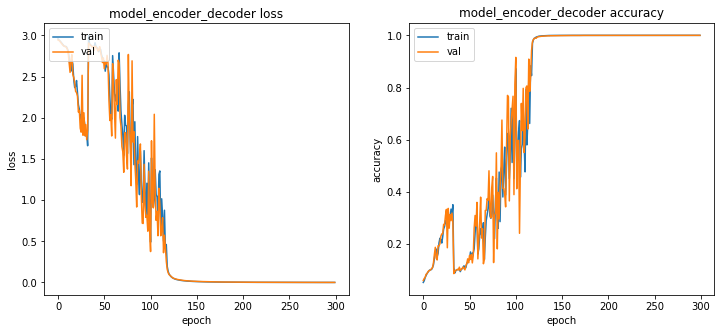

In [15]:
# let's remind the ``units = rnn_units``!
attention_lga = LuongGeneralAttention(rnn_units)  # n_timesteps_in
model_attention_lga, encoder_lstm_lga, decoder_lstm_lga, decoder_dense_lga = build_attention_model(
    attention_lga, batch_size, rnn_units)
_n_epochs, _patience = 300, 50
train_test(model_attention_lga, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=_n_epochs, patience=_patience)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":


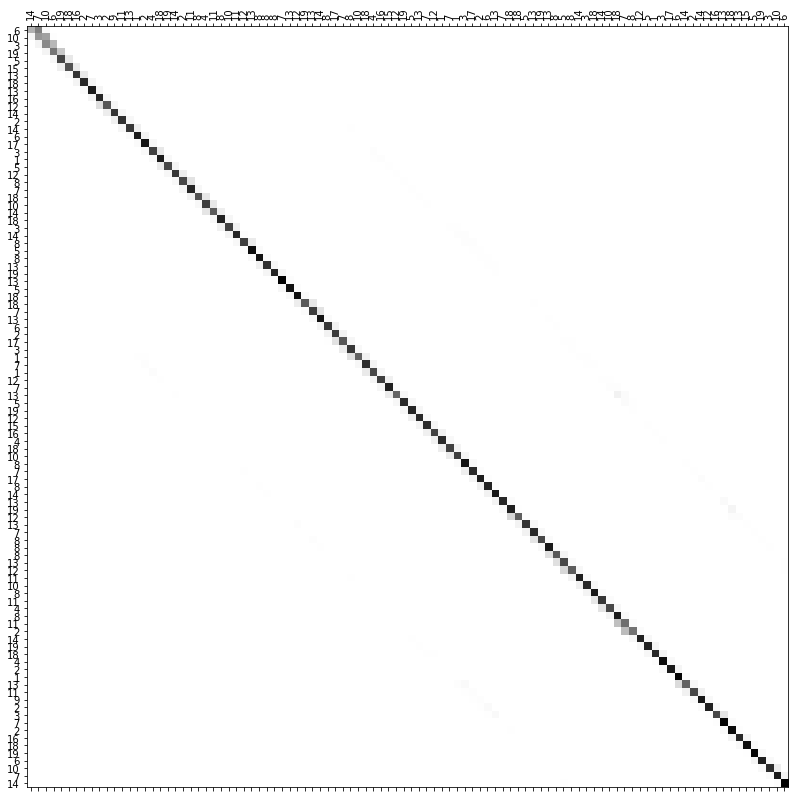

In [16]:
plot_attention_model_weights(
    test_seq, encoder_lstm_lga, decoder_lstm_lga, decoder_dense_lga, attention_lga)

# Comparative


After implementing all 3 different attention scores and train a model per each, the following results were sought:
- Luong Dot Attention: after training for 46 epochs, **83.505%** of accuracy in the **training set** and **83.790%** of accuracy in the **testing set** were obtained. However, the process was stopped by early-stopping at the 76th epoch (``patience = 30``).  
- Bahdanau Attention: after training for 74 epochs, **83.918%** of accuracy in the **training set** and **83.800%** of accuracy in the **testing set** were obtained. However, the process was stopped by early-stopping at the 104th epoch.
- Luong General Attention: after training for 300 epochs, **100.000%** of accuracy in the **training set** and **99.995%** of accuracy in the **testing set** were obtained. The process was stopped by the epochs scheduler, not because of over-fitting since the validation loss was still decreasing.

Apart from slight differents in the achieved performance, it is worth mention:
- The latent space in which the optimal models lie is really complex for the 2 first cases. At least, the loss plot shows how after an 'unstable' convergence process, the accuracy drops significatively.
- Regarding Luong Dot and Bahdanau attention mechanisms, the last one took longer to converge but achieve slightly better results.
- The Luong General Attention mechanism is much more complex than the other 2, but also more capable to learn and generalize. Since it took much longer to converge, the ``n_epochs`` and ``patience`` values were increased.
- The fact with the Luong General attention score the punctuation was higher is most probably due to the fact the training process was not stopped by early-stopping after an accuracty drop (like happenede before and to prevent it``patience`` values were increased). It could be possible for the other 2 scores that **with some more epochs and early-stopping patience, the accuracy was surpassed**. However, it is also worth noting that in the case of Luong General Attention the converge happened without huge loss/accuracy drops.

# Blog site

A more heuristic and intuitive idea of what attention is and how it works is provided in the following [link](https://hackmd.io/@Cb3b6527TACh1vRZ274gQw/rJx-AtZti).
Besides, the notebook was executed in the Kaggle platform to leverage GPU power. It is public there, as well, in this [link](https://www.kaggle.com/code/gerardcastro/dl-3rd-assignment). 